# Imports

In [1]:
import os, gc
import torch
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Pytorch lightning and forecasting

In [49]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import RMSE
from pytorch_lightning.loggers import TensorBoardLogger

# Load input

In [55]:
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../scratch/TFT_baseline'
    figPath = os.path.join(result_folder, 'figures')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_cleaned/Top_100.csv'

    configPath = '../configurations/baseline.json'

    model_path = os.path.join(checkpoint_folder, 'best-epoch=3.ckpt')
    ckpt_model_path = None

    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

    # interpret_output has high memory requirement
    # results in out-of-memery for Total.csv and a model of hidden size 64, even with 64GB memory
    interpret_train = 'Total.csv' not in input_filePath

In [5]:
start = datetime.now()
print(f'Started at {start}')

total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

Started at 2023-03-02 10:07:41.088958
(80900, 12)


,FIPS,AgeDist,HealthDisp,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,TimeFromStart,SinWeekly,CosWeekly
0,2261,0.014,8.8,2020-02-29,0.0,0.0,0.0,0.5,0.0,0,-0.975,-0.223
1,2261,0.014,8.8,2020-03-01,0.0,0.0,0.0,0.5,0.0,1,-0.782,0.623
2,2261,0.014,8.8,2020-03-02,0.0,0.0,0.0,0.5,0.0,2,0.000,1.000
3,2261,0.014,8.8,2020-03-03,0.0,0.0,0.0,0.5,0.0,3,0.782,0.623
4,2261,0.014,8.8,2020-03-04,0.0,0.0,0.0,0.5,0.0,4,0.975,-0.223


# Config

In [6]:
import json
import sys
sys.path.append( '..' )
from Class.Parameters import Parameters
from script.utils import *

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

In [7]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

batch_size = tft_params.batch_size
max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length

# Processing

In [8]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [9]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - total_data["Date"].min()).apply(lambda x: x.days)

## Train validation test split and scaling

In [92]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 64000, validation samples 2800, test samples 2800
640 days of training, 15 days of validation data, 15 days of test data.


In [20]:
train_scaled, validation_scaled, test_scaled, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AgeDist', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
Scaling targets ['Cases']


## Create dataset and dataloaders

In [106]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):
  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets[0],
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = GroupNormalizer(groups=pm.data.id),
    add_target_scales=True
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=batch_size*8)

  return data_timeseries, dataloader

In [107]:
train_timeseries, train_dataloader = prepare_data(train_data, parameters)
_, validation_dataloader = prepare_data(validation_data, parameters)
_, test_dataloader = prepare_data(test_data, parameters)

gc.collect()

2454

# Train

In [50]:
import tensorflow as tf
# click this and locate the lightning_logs folder path and select that folder. 
# this will load tensorbaord visualization
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [108]:
# notice that the early stopping patience is very high (60) for the old
# TF1 notebook. To reproduce that, replace patience=60
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=tft_params.early_stopping_patience
    , verbose=True, mode="min"
)

# https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.ModelCheckpoint.html
best_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=args.checkpoint_folder, monitor="val_loss", filename="best-{epoch}"
)
latest_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=args.checkpoint_folder, every_n_epochs=1, filename="latest-{epoch}"
)

logger = TensorBoardLogger(args.result_folder)  # logging results to a tensorboard

# https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-class-api
trainer = pl.Trainer(
    max_epochs = tft_params.epochs,
    accelerator = 'auto',
    enable_model_summary=True,
    gradient_clip_val = tft_params.clipnorm,
    callbacks = [early_stop_callback, best_checkpoint, latest_checkpoint],
    logger = logger,
    enable_progress_bar = args.show_progress_bar,
    check_val_every_n_epoch = 1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Model

In [109]:
# https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html
tft = TemporalFusionTransformer.from_dataset(
    train_timeseries,
    learning_rate= tft_params.learning_rate,
    hidden_size= tft_params.hidden_layer_size,
    attention_head_size=tft_params.attention_head_size,
    dropout=tft_params.dropout_rate,
    loss=RMSE(reduction='mean'), # RMSE(reduction='sqrt-mean')
    optimizer='adam',
    log_interval=1,
    # reduce_on_plateau_patience=2
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 21.6k


In [110]:
from datetime import datetime

gc.collect()

start = datetime.now()
print(f'\n----Training started at {start}----\n')

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
    ckpt_path=args.ckpt_model_path
)
end = datetime.now()
print(f'\n----Training ended at {end}, elapsed time {end-start}')
print(f'Best model by validation loss saved at {trainer.checkpoint_callback.best_model_path}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 


----Training started at 2023-03-02 11:38:49.052747----



Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 376667.250


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5565.438 >= min_delta = 0. New best score: 371101.812


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 32911.188 >= min_delta = 0. New best score: 338190.625


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 20289.219 >= min_delta = 0. New best score: 317901.406


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5675.656 >= min_delta = 0. New best score: 312225.750


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5476.438 >= min_delta = 0. New best score: 306749.312


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 14201.375 >= min_delta = 0. New best score: 292547.938


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3951.531 >= min_delta = 0. New best score: 288596.406


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 22412.156 >= min_delta = 0. New best score: 266184.250


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8003.594 >= min_delta = 0. New best score: 258180.656


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1260.812 >= min_delta = 0. New best score: 256919.844


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 256919.844. Signaling Trainer to stop.



----Training ended at 2023-03-02 11:46:33.855059, elapsed time 0:07:44.802312
Best model by validation loss saved at C:\Softwares\gpce-covid\TFT-pytorch\scratch\TFT_baseline\checkpoints\best-epoch=11.ckpt


In [105]:
# tft = TemporalFusionTransformer.load_from_checkpoint(args.model_path)
best_model_path = trainer.checkpoint_callback.best_model_path
print(f'Loading best model from {best_model_path}')
tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Prediction Processor and PlotResults

In [111]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

In [112]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

# Evaluate

## Train results

### Average


---Training prediction--



Predict:   0%|          | 0/120 [00:00<?, ? batches/s]


---Training results--

Target Cases, MAE 129.01, RMSE 325.08, RMSLE 1.7655, SMAPE 0.63815. NNSE 0.79721.



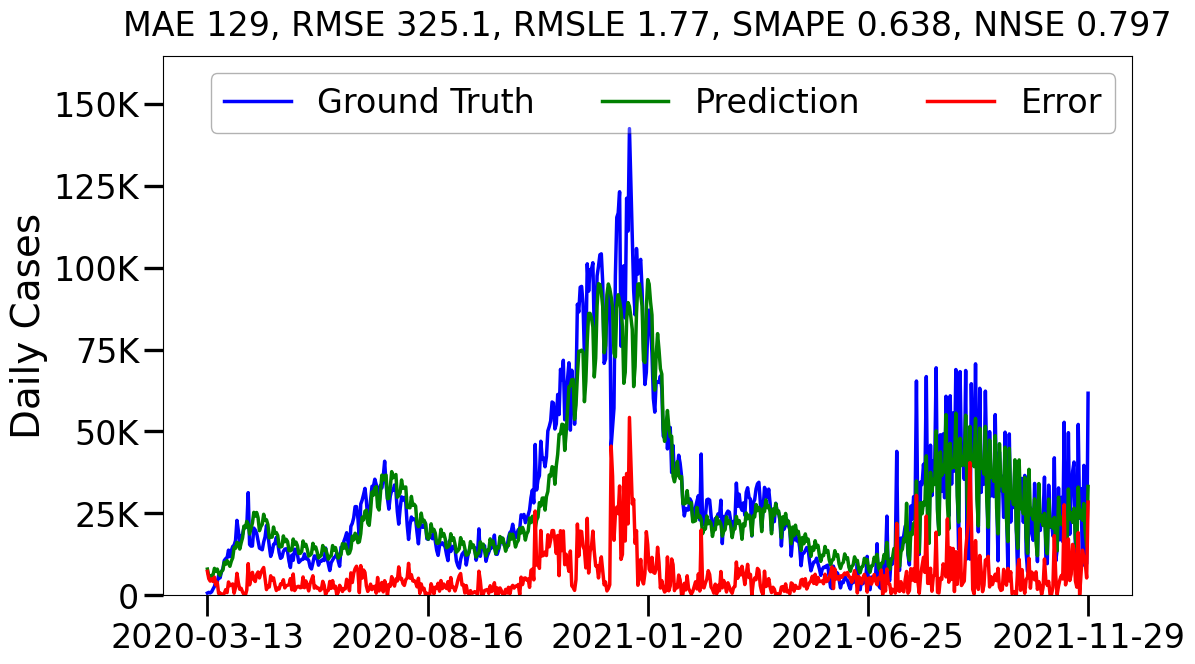

3667

In [113]:
print(f'\n---Training prediction--\n')

train_predictions, train_index = tft.predict(
    train_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)

print('\n---Training results--\n')
train_result_merged = processor.align_result_with_dataset(train_data, train_predictions, train_index)
show_result(train_result_merged, targets)

plotter.summed_plot(train_result_merged, type='Train_error', plot_error=True)
gc.collect()

## Validation results

In [ ]:
print(f'\n---Validation results--\n')
validation_predictions, validation_index = tft.predict(
    validation_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)

validation_result_merged = processor.align_result_with_dataset(validation_data, validation_predictions, validation_index)
show_result(validation_result_merged, targets)
plotter.summed_plot(validation_result_merged, type='Validation')
gc.collect()

## Test results

### Average

In [ ]:
print(f'\n---Test results--\n')
test_predictions, test_index = tft.predict(
    test_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)

test_result_merged = processor.align_result_with_dataset(test_data, test_predictions, test_index)
show_result(test_result_merged, targets)
plotter.summed_plot(test_result_merged, 'Test')
gc.collect()

## Dump results

In [ ]:
train_result_merged['split'] = 'train'
validation_result_merged['split'] = 'validation'
test_result_merged['split'] = 'test'
df = pd.concat([train_result_merged, validation_result_merged, test_result_merged])
df.to_csv(os.path.join(plotter.figPath, 'predictions.csv'), index=False)

df.head()

In [ ]:
del train_predictions, validation_predictions, test_predictions
gc.collect()

# Partial Dependency

In [230]:
total_data.describe()

,AgeDist,HealthDisp,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,TimeFromStart,SinWeekly,CosWeekly
count,80900.000000,80900.000000,80900.000000,80900.000000,80900.000000,80900.000000,80900.000000,80900.000000,80900.000000,80900.000000
mean,0.152780,4.597670,0.516527,387.517472,27.518977,0.970807,357.414326,404.000000,-0.001205,0.002216
std,0.034272,2.456936,0.200040,557.394435,29.934990,0.106116,858.611550,233.539449,0.707363,0.706887
min,0.014000,0.984000,-3.013000,-426.472000,0.000000,0.075000,0.000000,0.000000,-0.975000,-0.901000
25%,0.129500,2.755500,0.417000,89.686000,0.000000,1.000000,24.000000,202.000000,-0.782000,-0.901000
50%,0.148000,4.165500,0.506000,207.007000,8.900000,1.000000,119.000000,404.000000,0.000000,-0.223000
75%,0.173250,6.023750,0.606000,448.254000,58.000000,1.000000,349.000000,606.000000,0.782000,0.623000
max,0.294000,15.800000,3.837000,6592.769000,88.000000,1.000000,20618.250000,808.000000,0.975000,1.000000


## Util

In [243]:
def partial_dependency(
        df, feature, values=None, show_progress=True, figsize=(11,7),
        debug=False
    ):
    if values is None:
        min_value, max_value = df[feature].min(), df[feature].max()
        values = np.arange(min_value, max_value+1e-7, step=(max_value)/10)

    dependency = tft.predict_dependency(
        test_dataloader, feature, values, target='all'
        , show_progress_bar=show_progress, mode="dataframe"
    )
    if debug:
        print(f'Dependency.\n{dependency.head(3)}\n')

    agg_dependency  = dependency.groupby(feature).normalized_prediction.agg(
        median="median", q25=lambda x: x.quantile(0.25), 
        q75=lambda x: x.quantile(0.75)
    )
    if debug:
        print(f'Aggregated dependency\n{agg_dependency}\n.')

    ax = agg_dependency.plot(y="median", figsize=figsize)
    ax.fill_between(
        agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3
    )

## Static features

Predict:   0%|          | 0/11 [00:00<?, ? batches/s]

Dependency.
   TimeFromStart   FIPS  prediction  AgeDist  normalized_prediction  id
0            655  11001  296.741730      0.0                    1.0   0
1            655  12011   90.475906      0.0                    1.0   1
2            655  12031   34.133202      0.0                    1.0   2

Aggregated dependency
           median       q25       q75
AgeDist                              
0.0      1.000000  1.000000  1.000000
0.1      0.995147  0.954264  1.009393
0.2      0.996226  0.951954  1.023029
0.3      0.995270  0.951244  1.025278
0.4      0.998352  0.964966  1.027183
0.5      1.003219  0.970881  1.034982
0.6      1.006441  0.982351  1.040196
0.7      1.008342  0.986340  1.048515
0.8      1.010062  0.989070  1.050195
0.9      1.014156  0.991114  1.054499
1.0      1.016196  0.991927  1.054695
.


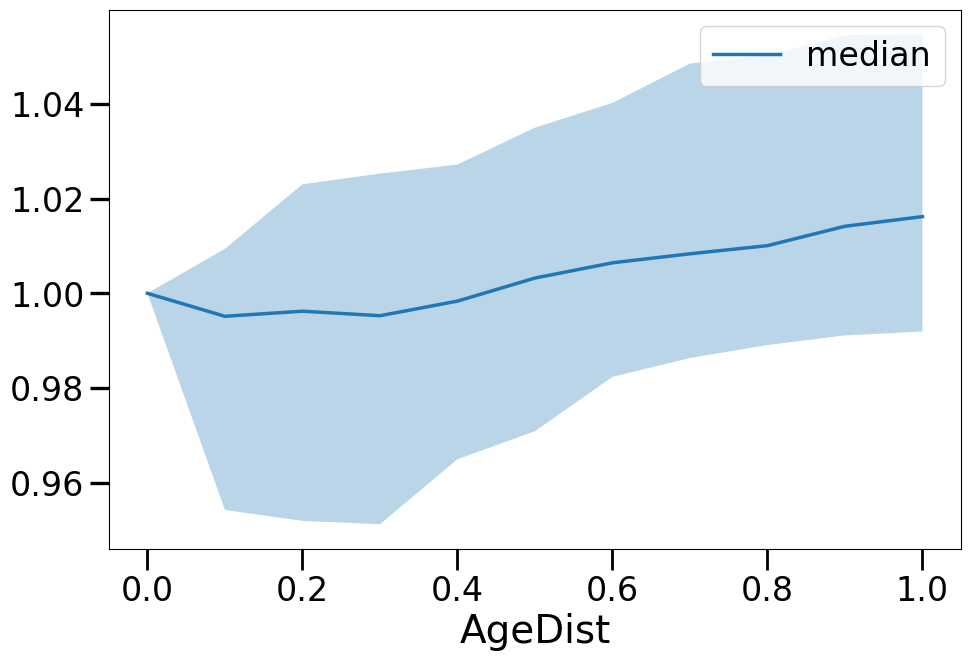

In [244]:
partial_dependency(
    test_data, 'AgeDist', values=np.arange(0, 1.001, 0.1), debug=True
)

Predict:   0%|          | 0/10 [00:00<?, ? batches/s]

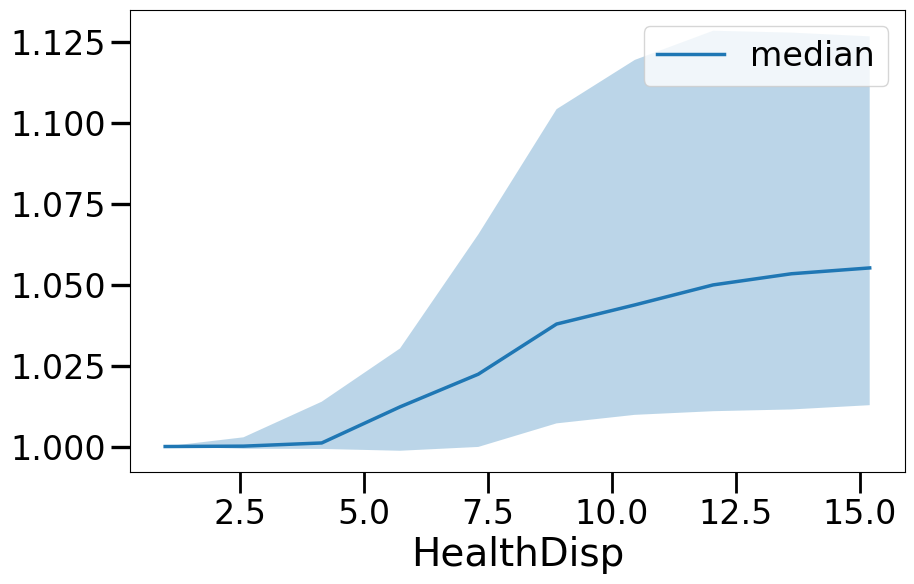

In [233]:
partial_dependency(test_data, 'HealthDisp')

## Dynamic features

Predict:   0%|          | 0/11 [00:00<?, ? batches/s]

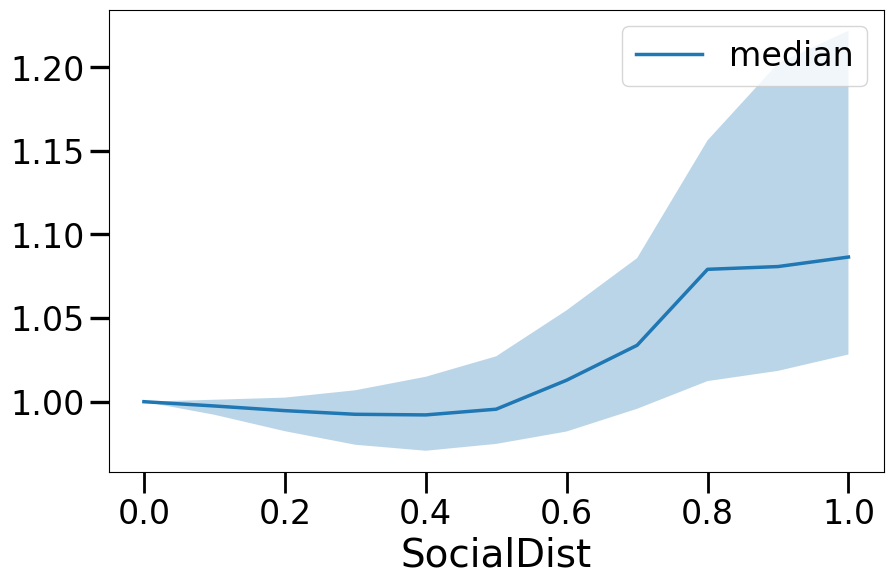

In [234]:
partial_dependency(
    test_data, 'SocialDist', values=np.arange(0, 1.001, step=0.1)
)

Predict:   0%|          | 0/11 [00:00<?, ? batches/s]

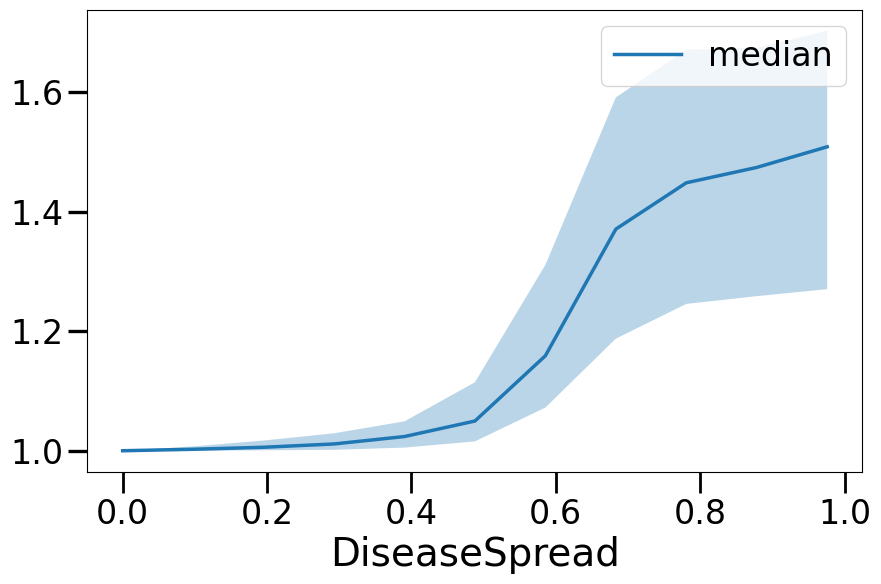

In [235]:
partial_dependency(test_data, 'DiseaseSpread')

Predict:   0%|          | 0/11 [00:00<?, ? batches/s]

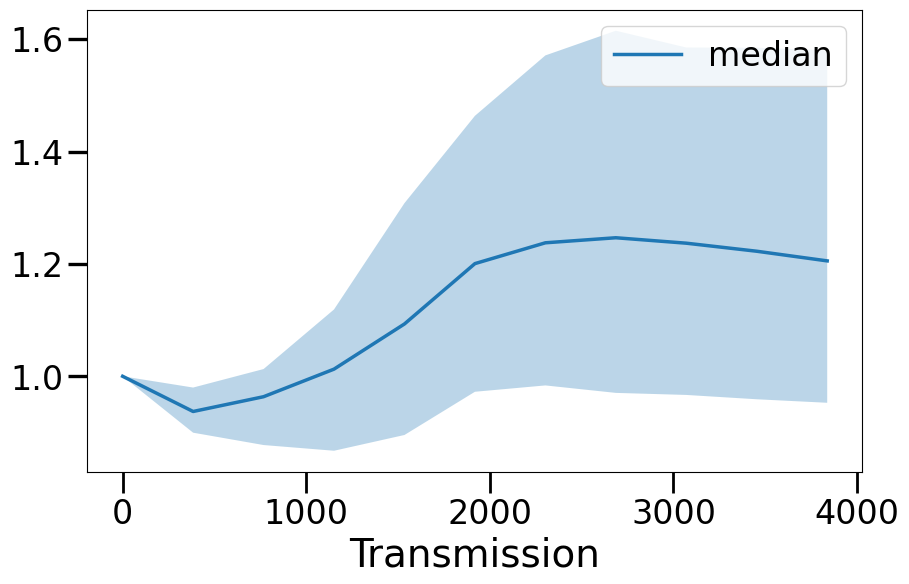

In [236]:
partial_dependency(test_data, 'Transmission')

Predict:   0%|          | 0/11 [00:00<?, ? batches/s]

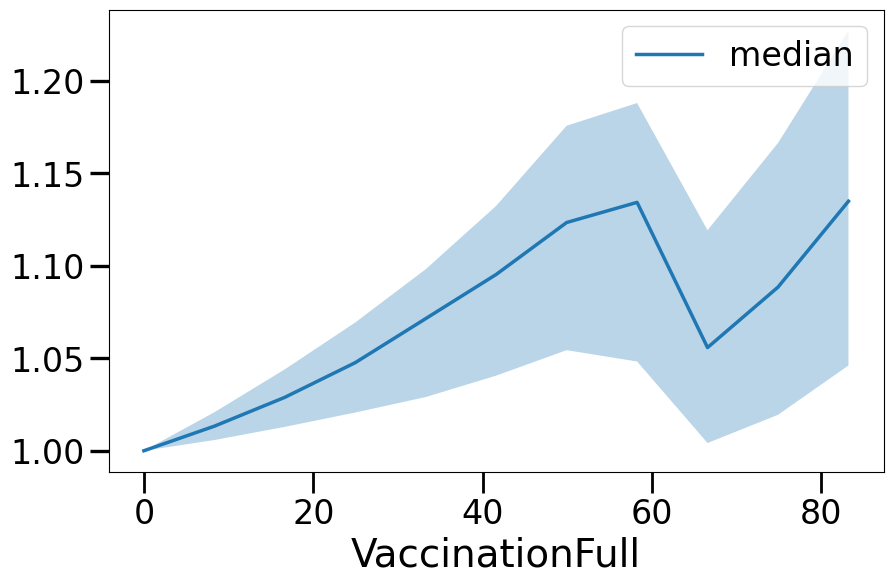

In [237]:
partial_dependency(test_data, 'VaccinationFull')

# End

In [ ]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')